# Track an experiment while training a Pytorch model locally or in your notebook

This notebook shows how you can use the SageMaker SDK to track a Machine Learning experiment using a Pytorch model trained locally.

We introduce two concepts in this notebook -

* *Experiment:* An experiment is a collection of runs. When you initialize a run in your training loop, you include the name of the experiment that the run belongs to. Experiment names must be unique within your AWS account. 
* *Run:* A run consists of all the inputs, parameters, configurations, and results for one iteration of model training. Initialize an experiment run for tracking a training job with Run(). 

To execute this notebook in SageMaker Studio, you should select the `PyTorch 1.12 Python 3.8 CPU Optimizer image`.


You can track artifacts for experiments, including datasets, algorithms, hyperparameters and metrics. Experiments executed on SageMaker such as SageMaker training jobs are automatically tracked and any existen SageMaker experiment on your AWS account is automatically migrated to the new UI version.

In this notebook we will demonstrate the capabilities through an MNIST handwritten digits classification example. The notebook is organized as follow:

1. Download and prepare the MNIST dataset
2. Train a Convolutional Neural Network (CNN) Model and log the model training metrics
3. Tune the hyperparameters that configures the number of hidden channels and the optimized in the model. Track teh parameter's configuration, resulting model loss and accuracy and automatically plot a confusion matrix using the Experiments capabilities of the SageMaker SDK.
4. Analyse your model results and plot graphs comparing your model different runs generated from the tunning step 3.

## Runtime
This notebook takes approximately 6~8 minutes to run.

## Reference to the github repo

[github link](https://github.com/aws/amazon-sagemaker-examples/tree/main/sagemaker-experiments)


## Contents
1. [Install modules](#Install-modules)
1. [Setup](#Setup)
1. [Download the dataset](#Download-the-dataset)
1. [Create experiment and log dataset information](#Create-experiment-and-log-dataset-information)
1. [Create model training functions](#Create-model-training-functions)
1. [Run first experiment](#Run-first-experiment)
1. [Run multiple experiments](#Run-multiple-experiments)

## Install modules

Let's ensure we have the latest SageMaker SDK available, including the SageMaker Experiments functionality

In [2]:
import sys

In [3]:
# update boto3 and sagemaker to ensure latest SDK version
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade boto3
!{sys.executable} -m pip install --upgrade sagemaker
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision

  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 49.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.27.84
    Uninstalling botocore-1.27.84:
      Successfully uninstalled botocore-1.27.84
  Attempting uninstall: boto3
    Found existing installation: boto3 1.24.84
    Uninstalling boto3-1.24.84:
      Successfully uninstalled boto3-1.24.84
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.25.85 requires botocore==1.27.84, but you have botocore 1.29.53 which is incompatible.
  Using cached sagemaker-2.129.0-

## Setup

Import required libraries and set logging and experiment configuration

SageMaker Experiments now provides the `Run` class that allows you to create a new experiment run. You can retrieve an existent experiment run using the `load_run` function.

You also define a unique name for the experiment that will be used to create and load the experiment later in this notebook

[documentation on experiment api](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments-create.html)

In [4]:
from torchvision import datasets, transforms #to download and transform mnist dataset
import torch

from sagemaker.session import Session  #to Manage interactions with the Amazon SageMaker APIs and any other AWS services needed.
from sagemaker.experiments.run import Run, load_run # A collection of parameters, metrics, and artifacts to create a ML model.
from sagemaker.utils import unique_name_from_base #adding unique id for a name

import os
import sys
import logging
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

experiment_name = unique_name_from_base("local-experiment-example") #unique 
run_name = "experiment-run"
print(experiment_name)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


local-experiment-example-1674202533-14d9


## Download the dataset
Let's now use the torchvision library to download the MNIST dataset from tensorflow and apply a transformation on each image

In [7]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
datasets.MNIST.urls = [
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-labels-idx1-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-labels-idx1-ubyte.gz",
]

train_set = datasets.MNIST(
    "mnist_data",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

test_set = datasets.MNIST(
    "mnist_data",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

View and example image from the dataset

In [6]:
print(" --training: ", len(train_set.data)," --testing: ",len(test_set.data))

 --training:  60000  --testing:  10000


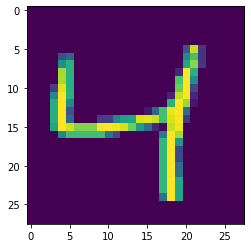

In [8]:
plt.imshow(train_set.data[2].numpy())

## Create experiment and log dataset information

Create an experiment run to track the model training. SageMaker Experiments is a great way to organize your data science work. You can create an experiment to organize all your model runs and analyse the different model metrics with the SageMaker Experiments UI.

Here we create an experiment run and log parameters for the size of our training and test datasets. We also log all the downloaded files as inputs to our model.

In [9]:
# create an experiment and start a new run
with Run(experiment_name=experiment_name, run_name=run_name, sagemaker_session=Session()) as run:
    run.log_parameters(
        {"num_train_samples": len(train_set.data), "num_test_samples": len(test_set.data)}
    )
    for f in os.listdir(train_set.raw_folder):
        print("Logging", train_set.raw_folder + "/" + f)
        run.log_file(train_set.raw_folder + "/" + f, name=f, is_output=False)

Logging mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Logging mnist_data/MNIST/raw/train-images-idx3-ubyte
Logging mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz
Logging mnist_data/MNIST/raw/t10k-images-idx3-ubyte
Logging mnist_data/MNIST/raw/t10k-labels-idx1-ubyte
Logging mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Logging mnist_data/MNIST/raw/train-images-idx3-ubyte.gz
Logging mnist_data/MNIST/raw/train-labels-idx1-ubyte


Checking the SageMaker Experiments UI, you can observe that a new Experiment was created with the run associated to it.

<img src="images/experiments_view.png" width="100%" style="float: left;" />
<img src="images/run_overview.png" width="100%" style="float: left;" />
<img src="images/parameters_overview1.png" width="100%" style="float: left;" />

## Create model training functions

Define your CNN architecture and training function. You can use `run.log_metric` with a defined step to log the metrics of your model for each epoch, in order to plot those metrics with SageMaker Experiments. With `run.log_confusion_matrix` you can automatically plot the confusion matrix of your model.

In [10]:
# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(torch.nn.Module):
    def __init__(self, hidden_channels, kernel_size, drop_out):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, hidden_channels, kernel_size=kernel_size)
        self.conv2 = torch.nn.Conv2d(hidden_channels, 20, kernel_size=kernel_size)
        self.conv2_drop = torch.nn.Dropout2d(p=drop_out)
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(x), 2))
        x = torch.nn.functional.relu(
            torch.nn.functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2)
        )
        x = x.view(-1, 320)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.nn.functional.log_softmax(x, dim=1)

In [13]:
def log_performance(model, data_loader, device, epoch, run, metric_type="Test"):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    loss /= len(data_loader.dataset)
    accuracy = 100.0 * correct / len(data_loader.dataset)
    print("loss: ", loss)
    print("accuracy: ",accuracy )
    # log metrics
    run.log_metric(name=metric_type + ":loss", value=loss, step=epoch)
    run.log_metric(name=metric_type + ":accuracy", value=accuracy, step=epoch)


def train_model(
    run, train_set, test_set, data_dir="mnist_data", optimizer="sgd", epochs=10, hidden_channels=10
):
    """
    Function that trains the CNN classifier to identify the MNIST digits.
    Args:
        run (sagemaker.experiments.run.Run): SageMaker Experiment run object
        train_set (torchvision.datasets.mnist.MNIST): train dataset
        test_set (torchvision.datasets.mnist.MNIST): test dataset
        data_dir (str): local directory where the MNIST datasource is stored
        optimizer (str): the optimization algorthm to use for training your CNN
                         available options are sgd and adam
        epochs (int): number of complete pass of the training dataset through the algorithm
        hidden_channels (int): number of hidden channels in your model
    """

    # log the parameters of your model
    run.log_parameter("device", "cpu")
    run.log_parameters(
        {
            "data_dir": data_dir,
            "optimizer": optimizer,
            "epochs": epochs,
            "hidden_channels": hidden_channels,
        }
    )

    # train the model on the CPU (no GPU)
    device = torch.device("cpu")

    # set the seed for generating random numbers
    torch.manual_seed(42)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)
    model = Net(hidden_channels, kernel_size=5, drop_out=0.5).to(device)
    model = torch.nn.DataParallel(model)
    momentum = 0.5
    lr = 0.01
    log_interval = 100
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        print("Training Epoch:", epoch)
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader, 1):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.functional.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        log_performance(model, train_loader, device, epoch, run, "Train")
        log_performance(model, test_loader, device, epoch, run, "Test")
    # log confusion matrix
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            run.log_confusion_matrix(target, pred, "Confusion-Matrix-Test-Data")

## Run first experiment

You can load an existent run using the `load_run` function with `experiment_name` and `run_name` as parameters. 
Here we train the CNN with 5 hidden channels and ADAM as optimizer. 

In [ ]:
%%time
with load_run(
    experiment_name=experiment_name, run_name=run_name, sagemaker_session=Session()
) as run:
    train_model(
        run=run,
        train_set=train_set,
        test_set=test_set,
        epochs=6,
        hidden_channels=2,
        optimizer="adam",
    )

INFO:sagemaker.experiments.run:The run (experiment-run) under experiment (local-experiment-example-1674202533-14d9) already exists. Loading it. Note: sagemaker.experiments.load_run is recommended to use when the desired run already exists.


Training Epoch: 1
loss:  0.14851033225854238
accuracy:  95.43833333333333
loss:  0.14054135818481445
accuracy:  95.45
Training Epoch: 2
loss:  0.13466343100667
accuracy:  95.94666666666667
loss:  0.12762430419921875
accuracy:  96.15
Training Epoch: 3


In the SageMaker Experiments UI, you can observe that the new model parameters are added to the run. The model training metrics are captured and can be used to plot graphs. Additionally, the confusion matrix graph is automatically plotted in the UI.

<img src="images/run_overview2.png" width="100%" style="float: left;" />
<img src="images/parameters_overview2.png" width="100%" style="float: left;" />
<img src="images/metrics_overview.png" width="100%" style="float: left;" />
<img src="images/charts_overview.png" width="100%" style="float: left;" />


## Run multiple experiments

You can now create multiple runs of your experiment using the functions created before

In the SageMaker Experiments UI, you can compare the different runs and analyze the metrics for those runs 


<img src="images/compare_experiments.png" width="100%"/>


In [18]:
## define a function to plot comparison of metrics between hyperparameters

# extract the table 
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.analytics import ExperimentAnalytics

def extract_table(experiment_name,output_metric, parameter_name,hue_name):
    ## output_metrics: str of metric to be traced
    ## parameter_names: str of parameter to be analyzed
    
    trial_component_analytics = ExperimentAnalytics(experiment_name=experiment_name,parameter_names=[parameter_name]+[hue_name])
    analytic_table = trial_component_analytics.dataframe()
    
    #filter the dataframe further
    df_cols=list(["TrialComponentName"])+[output_metric]+[parameter_name]+[hue_name]
    sub_table=analytic_table[df_cols]
    
    plot_table=sub_table[sub_table[output_metric]>=0]

    #remove experiment string from the TrialComponentName to make it neater
    plot_table["run"]=plot_table["TrialComponentName"].str.replace(experiment_name+'-experiment-', '')
    
    return plot_table


def plot_table(table,experiment_name,output_metric, parameter_name, hue_name):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    fig.suptitle('Experiment Analysis')

    # scatter plot here
    sns.scatterplot(ax=axes[0], x=table[parameter_name],y=table[output_metric], hue=table["run"])
    sns.scatterplot(ax=axes[1], x=table[parameter_name],y=table[output_metric], hue=table[hue_name])
    

    plt.tight_layout()
    plt.legend( title=experiment_name)
    plt.show()   
    return 

def analyze_experiment(experiment_name="training-job-experiment-1672305742-bcbe",output_metric="Test:loss - Last", parameter_name="hidden_channels", hue_name="optimizer"):
    
    print(experiment_name)   
    table=extract_table(experiment_name,output_metric, parameter_name,hue_name)
    print(experiment_name)
    plot_table(table,experiment_name,output_metric, parameter_name, hue_name )
    
    return table


In [ ]:
## define a function to plot comparison of metrics between hyperparameters

# extract the table 
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.analytics import ExperimentAnalytics

def extract_table(experiment_name,output_metric, parameter_name,hue_name):
    ## output_metrics: str of metric to be traced
    ## parameter_names: str of parameter to be analyzed
    
    trial_component_analytics = ExperimentAnalytics(experiment_name=experiment_name,parameter_names=[parameter_name]+[hue_name])
    analytic_table = trial_component_analytics.dataframe()
    
    #filter the dataframe further
    df_cols=list(["TrialComponentName"])+[output_metric]+[parameter_name]+[hue_name]
    sub_table=analytic_table[df_cols]
    
    plot_table=sub_table[sub_table[output_metric]>=0]

    #remove experiment string from the TrialComponentName to make it neater
    plot_table["run"]=plot_table["TrialComponentName"].str.replace(experiment_name+'-experiment-', '')
    
    return plot_table


def plot_table(table,experiment_name,output_metric, parameter_name, hue_name):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    fig.suptitle('Experiment Analysis')

    # scatter plot here
    sns.scatterplot(ax=axes[0], x=table[parameter_name],y=table[output_metric], hue=table["run"])
    sns.scatterplot(ax=axes[1], x=table[parameter_name],y=table[output_metric], hue=table[hue_name])
    

    plt.tight_layout()
    plt.legend( title=experiment_name)
    plt.show()   
    return 

def analyze_experiment(experiment_name="training-job-experiment-1672305742-bcbe",output_metric="Test:loss - Last", parameter_name="hidden_channels", hue_name="optimizer"):
    
    print(experiment_name)   
    table=extract_table(experiment_name,output_metric, parameter_name,hue_name)
    print(experiment_name)
    plot_table(table,experiment_name,output_metric, parameter_name, hue_name )
    
    return table


local-experiment-example-1674202533-14d9
local-experiment-example-1674202533-14d9


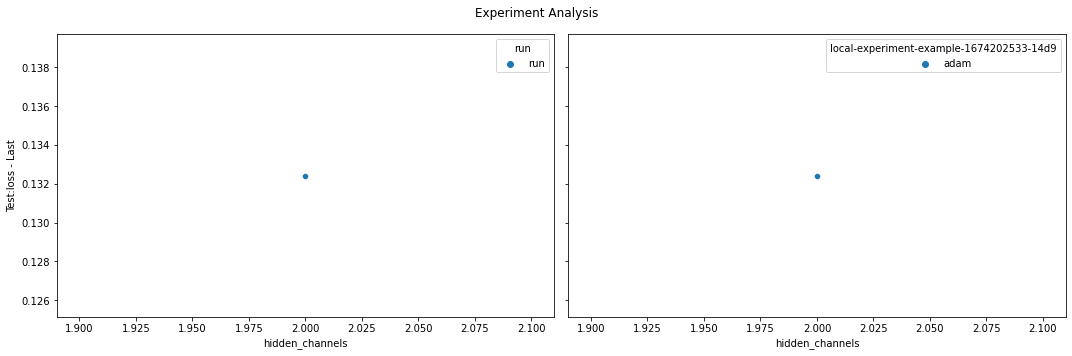

,TrialComponentName,Test:loss - Last,hidden_channels,optimizer,run
0,local-experiment-example-1674202533-14d9-exper...,0.132423,2.0,adam,run


In [19]:
analyze_experiment(experiment_name)